In [1]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_4096'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

xp = numpy


In [3]:
%run sequencing_sp.ipynb

In [4]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 'train_runs',
                                        'source_ds', 'test_image_id', 'true_value', 'infer_value', 'match_tab_index', 'match_score'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [5]:
hdc = Hdc(10_000, xp)

In [6]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 7 μs, sys: 0 ns, total: 7 μs
Wall time: 13.8 μs


((1000, 5), (200, 5))


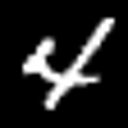
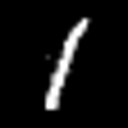
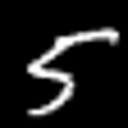
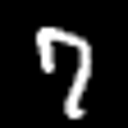
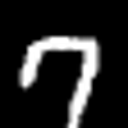
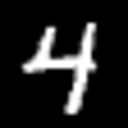
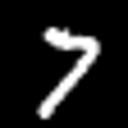
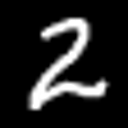
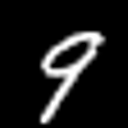
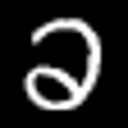
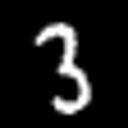
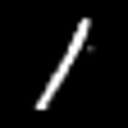
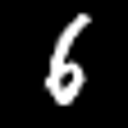
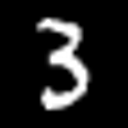
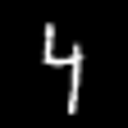
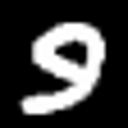

In [7]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [8]:
COS_SIM_45 = np.sqrt(2) / 2
COS_SIM_30 = np.sqrt(3) / 2

In [9]:
HOOK_HISTORY_LEN = 5
HOOK_LV_LEN = (1 + HOOK_HISTORY_LEN) * 4

In [10]:
def _calc_connection_vector(si_ind_from, si_ind_to, sensor_instance_ind_dict):
    si_from = sensor_instance_ind_dict[si_ind_from]
    si_to = sensor_instance_ind_dict[si_ind_to]
    return np.array([si_to.x - si_from.x, si_to.y - si_from.y])

def _calc_normal_vector(si_ind, sensor_instance_ind_dict):
    si = sensor_instance_ind_dict[si_ind]
    return np.array([si.normal_vec.real, si.normal_vec.imag])
    
def calc_si_connection_vectors(sequences, sensor_instance_ind_dict):
    connection_vectors_list = []
    
    for seq in sequences:
        seq_pairs = zip(seq[-1:] + seq[:-1], seq)
        cv = list(map(lambda si_inds: _calc_connection_vector(si_inds[0], si_inds[1], sensor_instance_ind_dict), seq_pairs))
        cv = np.array(cv)
        connection_vectors_list.append(cv)

    return connection_vectors_list

def calc_si_latent_vectors(sequences, sensor_instance_ind_dict):
    sensor_instance_ind_to_latent_vector = {}
    
    for seq in sequences:
        normal_vectors = list(map(lambda si_ind: _calc_normal_vector(si_ind, sensor_instance_ind_dict), seq))
        
        seq_pairs = zip(seq[-1:] + seq[:-1], seq)
        connection_vectors = list(map(lambda si_inds: _calc_connection_vector(si_inds[0], si_inds[1], sensor_instance_ind_dict), seq_pairs))
        connection_vectors = np.array(connection_vectors)
        connection_vectors = (connection_vectors.T / np.linalg.norm(connection_vectors, axis=1)).T
        
        neighbours_count_for_seq = min(HOOK_HISTORY_LEN, len(seq) - 1)
        
        # look-behind
        pre_vecs = deque()

        for i, si_ind in enumerate(seq[-neighbours_count_for_seq:]):
            normal_vector = normal_vectors[-neighbours_count_for_seq+i]
            connection_vector = connection_vectors[-neighbours_count_for_seq+i]
            pre_vecs.appendleft(np.hstack([normal_vector, connection_vector]))

        # look-ahead
        # post_vecs = deque()

        # for i, si_ind in enumerate(seq[1:1+neighbours_count_for_seq]):
        #     normal_vector = normal_vectors[i]
        #     connection_vector = connection_vectors[i]
        #     post_vecs.append(np.hstack([normal_vector, connection_vector]))

        # i_for_last_post = 0 + neighbours_count_for_seq
        # assert len(pre_vecs) == len(post_vecs)
        pads = [np.array([0, 0, 0, 0])] * (HOOK_HISTORY_LEN - neighbours_count_for_seq)
        
        for i, si_ind in enumerate(seq):
            # print(f'{i} {si_ind}')
            # print(f'{i} {si_ind} {connection_vectors[i]}')
            # print(f'{i} {si_ind} {pre_vecs}')
            latent_vector = []

            latent_vector_head = np.hstack([normal_vectors[i], connection_vectors[i]])
            latent_vector.append(latent_vector_head)
            latent_vector.append(np.array(list(pre_vecs) + pads).ravel())
            # latent_vector.append(np.array(list(post_vecs) + pads).ravel())
            
            latent_vector = np.hstack(latent_vector)
            # print(f'{i} {si_ind} {latent_vector}')
            assert latent_vector.shape == (HOOK_LV_LEN,), latent_vector.shape
            latent_vector = latent_vector / np.linalg.norm(latent_vector)
            sensor_instance_ind_to_latent_vector[si_ind] = latent_vector
    
            pre_vecs.pop()
            pre_vecs.appendleft(latent_vector_head)
            assert len(pre_vecs) == neighbours_count_for_seq

            # post_vecs.popleft()
            # i_for_last_post += 1
            # i_for_last_post = 0 if i_for_last_post >= len(seq) else i_for_last_post
            # post_vecs.append(np.hstack([normal_vectors[i_for_last_post], connection_vectors[i_for_last_post]]))
            # assert len(post_vecs) == neighbours_count_for_seq
        
    return sensor_instance_ind_to_latent_vector

def calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict):
    connection_vector_lengths = np.linalg.norm(connection_vectors, axis=1)
    seq_path_length = connection_vector_lengths.sum()
    seq_lv = np.zeros(1000, dtype='F')
    k = seq_lv.shape[0] / seq_path_length
    i = 0
    si_ind_to_offset = {}

    # Build sequence latent vector from a fixed number of normals - stretched or shrinked version of sequences as normals
    for si_ind, con_vec, con_vec_len in zip(seq, connection_vectors, connection_vector_lengths):
        i_from = int(i)
        i += con_vec_len * k
        i_to = min(int(i), seq_lv.shape[0] - 1)
        assert i_from >= 0, i_from
        assert i_to >= i_from, (i_to, i_from)
        assert i_to < seq_lv.shape[0], (i_to, seq_lv.shape[0])
        seq_lv[i_from:i_to] = sensor_instance_ind_dict[si_ind].normal_vec # repetition due to broadcasting
        si_ind_to_offset[si_ind] = i_from

        if i_to == seq_lv.shape[0] - 1:
            break

    return seq_lv, si_ind_to_offset

In [11]:
def render_image(image_id, df_images, image_sz=(600, 600), with_sequences=False, highlight_si_inds=set(), normal_color='red', highlight_color='darkred', lowlight_color='gray'):
    df_image = df_images.loc[image_id]
    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize(image_sz)
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    if not with_sequences:
        return image
        
    sensor_instance_ind_dict = pickle.loads(df_image['si'])
    sequences_full = pickle.loads(df_image['seq'])
    sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
    sequences_si = [list(map(lambda si_ind: sensor_instance_ind_dict[si_ind], seq)) for seq in sequences]
    
    for seq in sequences_si:
        for si_from, si_to in zip(seq, seq[1:] + seq[:1]):
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill=normal_color)
            
            color = normal_color

            if highlight_si_inds:
                color = highlight_color if si_from.Index in highlight_si_inds else lowlight_color

            # print(color)
            
            nl = 8 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline=color)
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill=color)
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_from.Index), anchor='mm', fill=color)

            color = normal_color
            
            if highlight_si_inds:
                color = highlight_color if si_to.Index in highlight_si_inds else lowlight_color
    
            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline=color)
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill=color)
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_to.Index), anchor='mm', fill=color)

    return image

In [12]:
SeqLatentVec = namedtuple('SeqLatentVec', 'engram_id seq_index si_ind lv')
Engram = namedtuple('Engram', 'engram_id, image_id value seqs_count seq_lvs')
HOOK_LVS = HdvArray(HOOK_LV_LEN, xp) # all vectors are normalized
SEQ_LV_DICT = {}
ENGRAM_DICT = {}
ENGRAM_ID_SOURCE = itertools.count(1)

In [13]:
%%time

train_runs = 1
count = min(100, len(df_train_images))

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    # image_ids = [28977]
    # image_ids = [10415]

    for image_id in image_ids:
        df_image = df_train_images.loc[image_id]
        sensor_instance_ind_dict = pickle.loads(df_image['si'])
        sequences_full = pickle.loads(df_image['seq'])
        sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
        sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
        connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
        assert len(connection_vectors_list) == len(sequences)

        engram = Engram(next(ENGRAM_ID_SOURCE), image_id, str(df_image['value']), len(sequences), [])
        ENGRAM_DICT[engram.engram_id] = engram

        for seq_index, (seq, connection_vectors)  in enumerate(zip(sequences, connection_vectors_list)):
            seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
                
            for i, si_ind in enumerate(seq):
                rolled_seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind])
                seq_lv_boxed = SeqLatentVec(engram.engram_id, seq_index, si_ind, rolled_seq_lv)
                engram.seq_lvs.append(seq_lv_boxed)

                lv = sensor_instance_ind_to_latent_vector[si_ind]
                latent_vector_i = HOOK_LVS.lease()
                HOOK_LVS.array_active[latent_vector_i] = lv
                
                SEQ_LV_DICT[latent_vector_i] = seq_lv_boxed                

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 160 ms, sys: 13 ms, total: 173 ms
Wall time: 172 ms


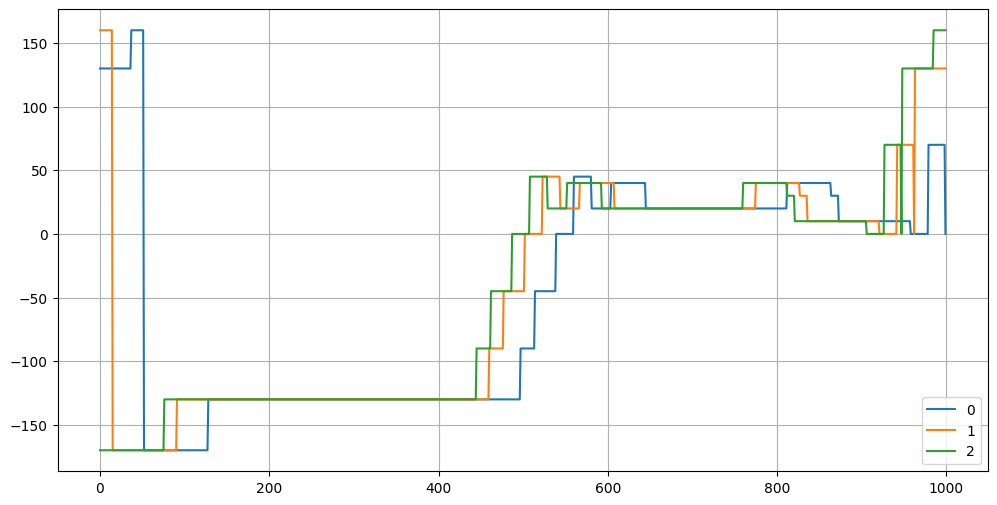

In [14]:
random_engram_id = RNG.choice(list(ENGRAM_DICT.keys()))
seq_lvs = ENGRAM_DICT[random_engram_id].seq_lvs[:3]

plt.figure(figsize=(12, 6))

for i, seq_lv_box in enumerate(seq_lvs):
    plt.plot(np.angle(seq_lv_box.lv, deg=True), label=str(i))
    
plt.grid()
plt.legend()
plt.show()

In [53]:
df_images = df_test_images
image_index = RNG.choice(df_images.index)
image_index = 100001440

df_image = df_images.loc[image_index]
sensor_instance_ind_dict = pickle.loads(df_image['si'])
sequences_full = pickle.loads(df_image['seq'])
sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)

In [54]:
sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
seq_lvs = []

for seq, connection_vectors in zip(sequences, connection_vectors_list):
    seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
    seq_lvs.append((seq_lv, si_ind_to_offset))

In [126]:
engram_to_match_mat = {}
seqs_inspection = {}

# Check every sequence of an image under study
for seq_index, seq in enumerate(sequences):
    seq_lv, si_ind_to_offset = seq_lvs[seq_index]
    # Explore various hooks - one may be better than other due to different phases of rolled seq_lv
    si_inds = RNG.choice(seq, min(5, len(seq)), replace=False)
    seqs_inspection[seq_index] = si_inds

    for si_ind  in si_inds:
        si_lv = sensor_instance_ind_to_latent_vector[si_ind]
        seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind]) # phasing
        cos_sims = HOOK_LVS.array_active @ si_lv
        cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
        
        for cos_sim_index in cos_sim_indices:
            candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
            candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]
        
            seq_lv_diff = candidate_seq_lv_box.lv - seq_lv
            error_score = np.sum(np.absolute(seq_lv_diff) ** 2)

            if not candidate_engram.engram_id in engram_to_match_mat:
                engram_to_match_mat[candidate_engram.engram_id] = np.full((candidate_engram.seqs_count, len(sequences)), np.inf)

            match_mat = engram_to_match_mat[candidate_engram.engram_id]
            match_mat_score = match_mat[candidate_seq_lv_box.seq_index, seq_index]

            if error_score < match_mat_score:
                match_mat[candidate_seq_lv_box.seq_index, seq_index] = error_score

match_tab = defaultdict(list)

for engram_id, match_mat in engram_to_match_mat.items():
    # Reduce match matrix to vector of least error scores for each column (each sequence of image under study)
    match_vector = np.full(len(sequences), np.inf)
    assert len(sequences) == match_mat.shape[1]
    match_mat_work = match_mat.copy()
    
    for j in range(match_mat_work.shape[1]):
        i = np.argmin(match_mat_work[:,j])
        match_vector[j] = match_mat_work[i,j]
        match_mat_work[:,j] = np.inf
        match_mat_work[i,:] = np.inf
        
    match_tab['image_id'].append(image_index)
    match_tab['value'].append(df_image['value'])

    candidate_engram = ENGRAM_DICT[engram_id]
    match_tab['candidate_engram_id'].append(engram_id)
    match_tab['candidate_image_id'].append(candidate_engram.image_id)
    match_tab['candidate_value'].append(candidate_engram.value)
    match_tab['match_mat'].append(match_mat)
    match_tab['match_vector'].append(match_vector)
    match_tab['match_score'].append(np.sum(match_vector))

df_match_tab = pd.DataFrame(match_tab)
df_match_tab.sort_values(by=['match_score'], inplace=True)
df_match_tab

,image_id,value,candidate_engram_id,candidate_image_id,candidate_value,match_mat,match_vector,match_score
23,100001440,4,25,40493,4,[[487.11676025390625]],[487.11676025390625],487.116760
90,100001440,4,97,36274,6,"[[inf], [587.6895751953125]]",[587.6895751953125],587.689575
3,100001440,4,4,36996,6,"[[598.9097900390625], [inf]]",[598.9097900390625],598.909790
42,100001440,4,44,52877,6,"[[606.239501953125], [inf]]",[606.239501953125],606.239502
0,100001440,4,1,34697,6,[[634.6826171875]],[634.6826171875],634.682617
...,...,...,...,...,...,...,...,...
9,100001440,4,11,39741,3,[[1729.54541015625]],[1729.54541015625],1729.545410
26,100001440,4,28,7259,2,[[1752.124755859375]],[1752.124755859375],1752.124756
19,100001440,4,21,54668,4,[[1799.527587890625]],[1799.527587890625],1799.527588
96,100001440,4,60,31220,6,"[[1857.9013671875], [inf]]",[1857.9013671875],1857.901367


In [128]:
seqs_inspection

{0: array([318, 360,  94, 359, 120])}

In [96]:
def get_activated_hook_si_inds(si_ind, image_id):
    si_lv = sensor_instance_ind_to_latent_vector[si_ind]
    cos_sims = HOOK_LVS.array_active @ si_lv
    cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
    rv = []
    
    for cos_sim_index in cos_sim_indices:
        candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
        candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]

        if candidate_engram.image_id != image_id:
            continue

        rv.append(candidate_seq_lv_box.si_ind)

    return rv


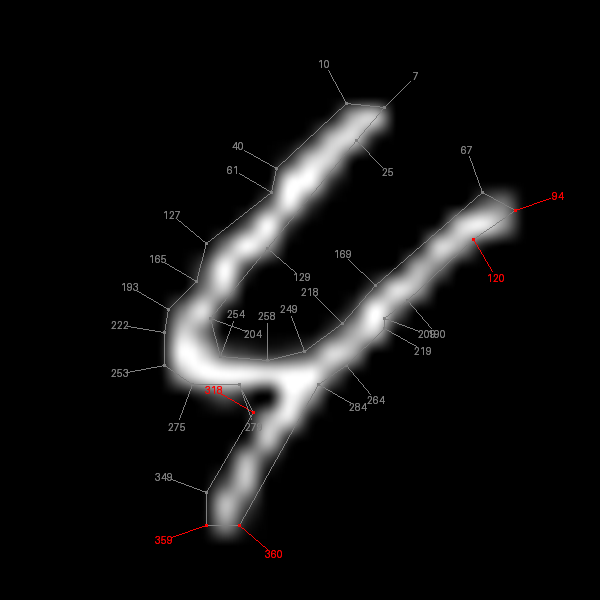
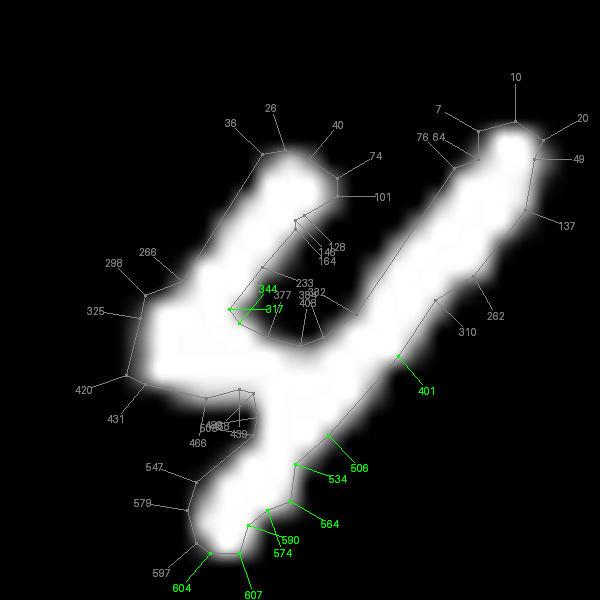

In [137]:
best_candidate_image_id = int(df_match_tab.iloc[0]['candidate_image_id'])
image1 = render_image(image_index, df_test_images,
                      with_sequences=True,
                      highlight_si_inds=list(itertools.chain.from_iterable(seqs_inspection.values())),
                      normal_color='gray', highlight_color='red', lowlight_color='gray')
# image2 = render_image(best_candidate_image_id, df_train_images, 
image2 = render_image(40493, df_train_images, 
                      with_sequences=True,
                      highlight_si_inds=get_activated_hook_si_inds(360, 40493),
                      # highlight_si_inds=set([185]), 
                      normal_color='gray', highlight_color='lime', lowlight_color='gray')
display_images([image1, image2], captions=[f'{image_index}, {df_image['value']}', f'{best_candidate_image_id}'])

In [138]:
zzz = {}

for seq_index, seq in enumerate(sequences):
    seq_lv, si_ind_to_offset = seq_lvs[seq_index]

    for si_ind in [360]:
        si_lv = sensor_instance_ind_to_latent_vector[si_ind]
        seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind]) # phasing
        cos_sims = HOOK_LVS.array_active @ si_lv
        cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
        
        for cos_sim_index in cos_sim_indices:
            candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
            candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]

            if candidate_engram.image_id == 40493:
                seq_lv_diff = candidate_seq_lv_box.lv - seq_lv
                error_score = np.sum(np.absolute(seq_lv_diff) ** 2)
                zzz[candidate_seq_lv_box.si_ind] = (seq_lv_diff, seq_lv, candidate_seq_lv_box.lv)

In [139]:
zzz.keys()

dict_keys([317, 344, 401, 506, 534, 564, 574, 590, 607, 604])

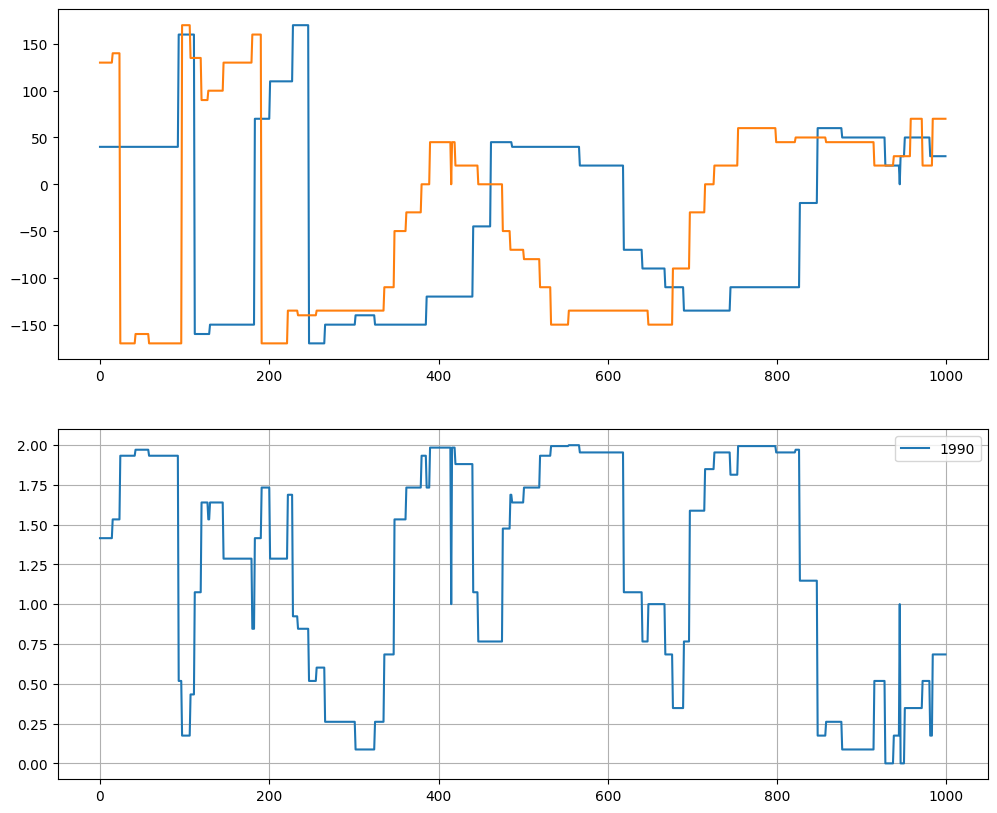

In [150]:
plt.figure(figsize=(12, 10))


# for si_ind in [534]:
for si_ind in [604]:
    plt.subplot(2, 1, 1)
    # plt.plot(np.absolute(zzz[si_ind]), label=f'{si_ind}; {np.sum(np.absolute(zzz[si_ind]) ** 2):.0f}')
    plt.plot(np.angle(zzz[si_ind][1], deg=True), label=f'us')
    plt.plot(np.angle(zzz[si_ind][2], deg=True), label=f'cand')
    plt.subplot(2, 1, 2)
    plt.plot(np.absolute(zzz[si_ind][0]), label=f'{np.sum(np.absolute(zzz[si_ind][0]) ** 2):.0f}')

plt.legend()
plt.grid()
plt.show()

In [32]:
# TEST RUN
TEST_RUN_ID += 1
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
count = min(2000, len(test_run_source[0]))
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
match_tabs = []

for image_id in tqdm(test_image_ids):
    df_image = test_run_source[0].loc[image_id]
    image_value = df_image['value']
    sensor_instance_ind_dict = pickle.loads(df_image['si'])
    sequences_full = pickle.loads(df_image['seq'])
    sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)    
    sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
    connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
    seq_lvs = []
    
    for seq, connection_vectors in zip(sequences, connection_vectors_list):
        seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
        seq_lvs.append((seq_lv, si_ind_to_offset))

    engram_to_match_mat = {}
    
    # Check every sequence of an image under study
    for seq_index, seq in enumerate(sequences):
        seq_lv, si_ind_to_offset = seq_lvs[seq_index]
        # Explore various hooks - one may be better than other due to different phases of rolled seq_lv
        si_inds = RNG.choice(seq, min(5, len(seq)), replace=False)
    
        for si_ind  in si_inds:
            si_lv = sensor_instance_ind_to_latent_vector[si_ind]
            seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind]) # phasing
            cos_sims = HOOK_LVS.array_active @ si_lv
            cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
            
            for cos_sim_index in cos_sim_indices:
                candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
                candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]
            
                seq_lv_diff = candidate_seq_lv_box.lv - seq_lv
                error_score = np.sum(np.absolute(seq_lv_diff) ** 2)
    
                if not candidate_engram.engram_id in engram_to_match_mat:
                    engram_to_match_mat[candidate_engram.engram_id] = np.full((candidate_engram.seqs_count, len(sequences)), np.inf)
    
                match_mat = engram_to_match_mat[candidate_engram.engram_id]
                match_mat_score = match_mat[candidate_seq_lv_box.seq_index, seq_index]
    
                if error_score < match_mat_score:
                    match_mat[candidate_seq_lv_box.seq_index, seq_index] = error_score
    
    match_tab = defaultdict(list)
    
    for engram_id, match_mat in engram_to_match_mat.items():
        # Reduce match matrix to vector of least error scores for each column (each sequence of image under study)
        match_vector = np.full(len(sequences), np.inf)
        assert len(sequences) == match_mat.shape[1]
        match_mat_work = match_mat.copy()
        
        for j in range(match_mat_work.shape[1]):
            i = np.argmin(match_mat_work[:,j])
            match_vector[j] = match_mat_work[i,j]
            match_mat_work[:,j] = np.inf
            match_mat_work[i,:] = np.inf
            
        candidate_engram = ENGRAM_DICT[engram_id]
        match_tab['candidate_engram_id'].append(engram_id)
        match_tab['candidate_image_id'].append(candidate_engram.image_id)
        match_tab['candidate_value'].append(candidate_engram.value)
        match_tab['match_mat'].append(match_mat)
        match_tab['match_vector'].append(match_vector)
        match_tab['match_score'].append(np.sum(match_vector))

    df_match_tab = pd.DataFrame(match_tab)
    df_match_tab.sort_values(by=['match_score'], inplace=True)
    match_tabs.append(df_match_tab)

    if len(df_match_tab) > 0:
        infer_value = df_match_tab.iloc[0]['candidate_value']
    else:
        infer_value = ''
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append([])
    test_result_rows['train_images_count'].append(len(ENGRAM_DICT))
    test_result_rows['train_runs'].append(TRAIN_RUN_ID)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['match_score'].append(df_match_tab.iloc[0]['match_score'])
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)
    

assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/200 [00:00<?, ?it/s]

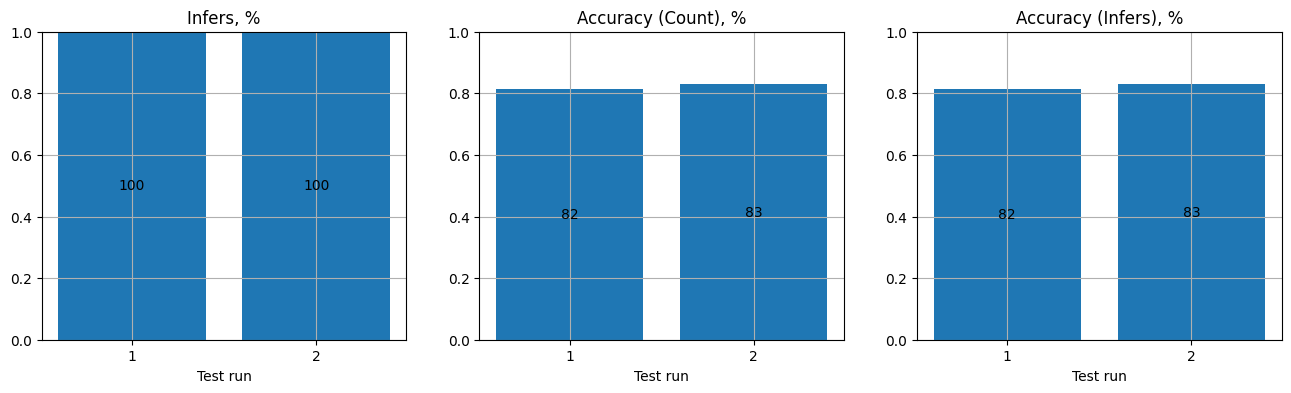

,config_variant,source_ds,cortical_columns,train_images_count,train_runs,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
1,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,200,200,163,1.0,0.815,0.815
2,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,200,200,166,1.0,0.830,0.830


In [33]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [36]:
df_last_run_results = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == max(DF_TEST_RESULTS.test_run_id)]
df_incorrect = df_last_run_results.loc[df_last_run_results.true_value != df_last_run_results.infer_value]
df_incorrect

,test_run_id,config_variant,cortical_columns,train_images_count,train_runs,source_ds,test_image_id,true_value,infer_value,match_tab_index,match_score
201,2,SQLITE3_SEQ_GRID_0_4096,[],100,1,test,100003012,8,6,1,993.278473
203,2,SQLITE3_SEQ_GRID_0_4096,[],100,1,test,100003445,0,8,3,299.409622
209,2,SQLITE3_SEQ_GRID_0_4096,[],100,1,test,100003311,5,8,9,497.569427
213,2,SQLITE3_SEQ_GRID_0_4096,[],100,1,test,100000010,0,8,13,289.032753
214,2,SQLITE3_SEQ_GRID_0_4096,[],100,1,test,100009117,5,7,14,507.821960
229,2,SQLITE3_SEQ_GRID_0_4096,[],100,1,test,100008207,9,6,29,718.755127
243,2,SQLITE3_SEQ_GRID_0_4096,[],100,1,test,100001202,8,2,43,1352.604279
249,2,SQLITE3_SEQ_GRID_0_4096,[],100,1,test,100009422,5,9,49,445.604858
250,2,SQLITE3_SEQ_GRID_0_4096,[],100,1,test,100005775,8,6,50,552.494659
254,2,SQLITE3_SEQ_GRID_0_4096,[],100,1,test,100006755,8,0,54,546.755066


In [46]:
df_last_run_results.loc[df_last_run_results.true_value == df_last_run_results.infer_value].match_score.describe()

count     166.000000
mean      411.809742
std       275.326962
min        64.033051
25%       246.467377
50%       355.550941
75%       518.968079
max      2717.111938
Name: match_score, dtype: float64

In [44]:
df_last_run_results.loc[(df_last_run_results.true_value != df_last_run_results.infer_value) & (np.isfinite(df_last_run_results.match_score))].match_score.describe()

count      31.000000
mean      800.898119
std       735.926205
min       176.423706
25%       454.718658
50%       552.297363
75%       851.810852
max      4098.815186
Name: match_score, dtype: float64

In [52]:
match_tabs[186]

,candidate_engram_id,candidate_image_id,candidate_value,match_mat,match_vector,match_score
35,97,36274,6,"[[inf], [552.29736328125]]",[552.29736328125],552.297363
22,56,35795,6,"[[579.9661865234375], [inf]]",[579.9661865234375],579.966187
23,60,31220,6,"[[582.449462890625], [inf]]",[582.449462890625],582.449463
10,25,40493,4,[[582.678955078125]],[582.678955078125],582.678955
17,44,52877,6,"[[598.0718383789062], [inf]]",[598.0718383789062],598.071838
...,...,...,...,...,...,...
71,58,4057,5,[[1906.399169921875]],[1906.399169921875],1906.399170
51,26,2970,1,[[2145.05615234375]],[2145.05615234375],2145.056152
96,93,46335,1,[[2158.622314453125]],[2158.622314453125],2158.622314
50,22,24357,1,[[2334.7314453125]],[2334.7314453125],2334.731445


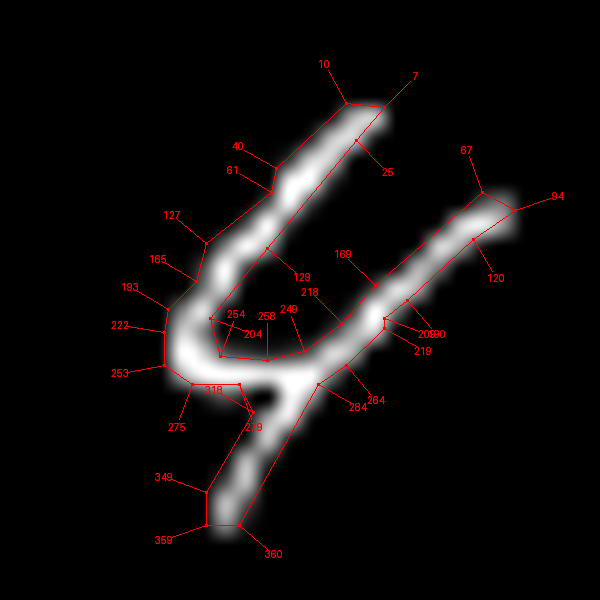

In [47]:
render_image(100001440, df_test_images, with_sequences=True)

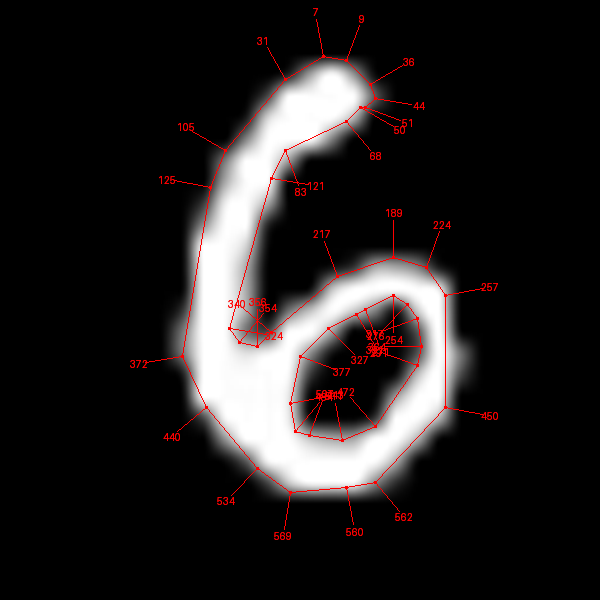

In [49]:
render_image(36274, df_train_images, with_sequences=True)